In [64]:
import pandas as pd
import numpy as np
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import itertools
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel

from feature_engine.selection import DropDuplicateFeatures

from optbinning import BinningProcess, OptimalBinning

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Load train data

For our analysis, we will use the training dataset located at `./data/train.csv`

This Dataset is the training dataset in a Hackathon organized by Deloitte. The aim is to predict whether a person will be a loan defaulter or not by looking at various attributes like funded amount, location, loan, balance, etc. In reality, banks and finance institutions would create credit scorecards for such tasks and rank their customers by credit score.

In this analysis, we will focus more on exploratory data analysis to find out the top 10 variables contributing most significantly to the probability of default. Our task is to explore the relationship between the independent variables and the target variable, perform some transformation and encoding techniques to have a dataset ready for fitting into a logistic regression model.

In [3]:
df = pd.read_csv('./data/train.csv')

df.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


Brief description of columns:

- `ID`: unique ID of representative
- `Loan Amount`: loan amount applied
- `Funded Amount`: loan amount funded
- `Funded Amount Investor`: loan amount approved by the investors
- `Term`: term of loan (in months)
- `Batch Enrolled`: batch numbers to representatives
- `Interest Rate`: interest rate (%) on loan
- `Grade`: grade by the bank
- `Sub Grade`: sub-grade by the bank
- `Employment Duration`: duration
- `Home Ownership`: Ownership of home
- `Verification Status`: Income verification by the bank
- `Payment Plan`: if any payment plan has started against loan
- `Loan Title`: loan title provided
- `Debit to Income`: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
- `Delinquency - two years`: number of 30+ days delinquency in past 2 years
- `Inquiries - six months`: total number of inquiries in last 6 months
- `Open Account`: number of credit line in representative's credit line
- `Public Records`: number of derogatory public records
- `Revolving Balance`: total credit revolving balance
- `Revolving Utilities`: amount of credit a representative is using relative to Revolving Balance
- `Total Accounts`: total number of credit lines available in representative's credit lines
- `Initial List Status`: unique listing status of the loan - W(Waiting), F(Forwarded)
- `Total Received Interest`: total interest received till date
- `Total Received Late Fee`: total late fee received till date
- `Recoveries`: post charge off gross recovery
- `Collection Recovery Fee`: post charge off collection fee
- `Collection 12 months Medical`: total collections in last 12 months excluding medical collections
- `Application Type`: indicates when the representative is an individual or joint
- `Last week Pay`: indicates how long (in weeks) a representative has paid EMI after batch enrolled
- `Accounts Delinquent`: number of accounts on which the representative is delinquent
- `Total Collection Amount`: total current balance from all accounts
- `Total Current Balance`: total current balance from all accounts
- `Total Revolving Credit Limit`: total revolving credit limit
- `Loan Status`: 1 = Defaulter, 0 = Non-defaulter

In [4]:
# check the number of rows and columns
df.shape

(67463, 35)

In [5]:
# Displays column names, complete (non-missing) cases per column, and datatype per column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [6]:
# get some descriptive statistics
# for categorical variables, we will also see the number of unique values
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,67463.0,NaN,NaN,NaN,25627607.746498,21091554.023733,1297933.0,6570288.0,17915646.0,42715208.5,72245779.0
Loan Amount,67463.0,NaN,NaN,NaN,16848.902776,8367.865726,1014.0,10012.0,16073.0,22106.0,35000.0
Funded Amount,67463.0,NaN,NaN,NaN,15770.599114,8150.992662,1014.0,9266.5,13042.0,21793.0,34999.0
Funded Amount Investor,67463.0,NaN,NaN,NaN,14621.799323,6785.34517,1114.590204,9831.684984,12793.68217,17807.59412,34999.74643
Term,67463.0,NaN,NaN,NaN,58.173814,3.327441,36.0,58.0,59.0,59.0,59.0
Batch Enrolled,67463,41,BAT3873588,3626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interest Rate,67463.0,NaN,NaN,NaN,11.846258,3.718629,5.320006,9.297147,11.377696,14.193533,27.182348
Grade,67463,7,C,19085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub Grade,67463,35,B4,4462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment Duration,67463,3,MORTGAGE,36351,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# let's separate the data into target and variables
target = 'Loan Status'

y = df[target]
X = df[[var for var in df.columns if var not in [target, 'ID']]]

In [8]:
X.shape, y.shape

((67463, 33), (67463,))

## 2. Drop constant, quasi-constant, and duplicate variables

First, let's identify constant and quasi-constant variables in our dataset using a variance threshold. Variables that have lower variance than this threshold will be considered a (quasi)constant variable and will be dropped from the analysis as they will not add any useful information towards whether a person is a defaulter.

We can use `sklearn.feature_selection.VarianceThreshold` to drop features with variance below a certain threshold, but the method is only applicable to numeric variables. If we want to apply the variance threshold method on non-numeric variables, we have to code it ourselves.

In [9]:
class DropQuasiConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, predominant_threshold=0.998):
        self.predominant_threshold = predominant_threshold
        # create an empty list to store quasi-constant features
        self.quasi_constant_features = []
        
    def fit(self, X, y=None):
        for feature in X.columns:
            # find the predominant value (shared by most observations):
            predominant = X[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
            # evaluate the predominant value frequency: does it exceed the threshold?
            if predominant > self.predominant_threshold:
                # if yes, add the feature to the list
                self.quasi_constant_features.append(feature)

        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.drop(self.quasi_constant_features, axis=1, inplace=True)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [10]:
drop_quasi_constant = DropQuasiConstantFeatures()
# we use the fit method to get the list of quasi-constant variables
quasi_constant_vars = drop_quasi_constant.fit(X).quasi_constant_features

print('Quasi-constant features:', quasi_constant_vars)

Quasi-constant features: ['Payment Plan', 'Application Type', 'Accounts Delinquent']


Let's also check if our dataset contains any duplicated variables, that is, features with different names but are identical in values. Since there is not built-in method for detecting and removing duplicated variables in pandas or sklearn, we'll use a different open-source package `feature_engine` to accomplish this.

In [11]:
# set up a selector using feature_engine.selection.DropDuplicateFeatures
drop_duplicate = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features
drop_duplicate.fit(X)

# let's check if there are any pairs of duplicated features
drop_duplicate.duplicated_feature_sets_

[]

Good thing that our dataset does not have any duplicated variables.

We can split our variables into categorical and numerical ones, excluding the quasi-constant variables.

In [12]:
categorical_vars = [var for var in X.columns if var not in quasi_constant_vars and X[var].dtype=='object']
numerical_vars = [var for var in X.columns if var not in quasi_constant_vars and var not in categorical_vars]

# let's check out the number of categorical variables and numerical variables
print('Number of categorical variables:', len(categorical_vars))
print('Number of numerical variables:', len(numerical_vars))

Number of categorical variables: 7
Number of numerical variables: 23


## 3. Target variable - Loan Status

Let's inspect the target variable - `Loan Status`. This is a binary variable, with `0` = Non-defaulter and `1` = Defaulter.


In [13]:
# the overall default rate
default_perc = sum(y) / y.shape[0]

print(f'The overall default rate is: {default_perc:.4f}')

The overall default rate is: 0.0925


Our dataset is highly imbalanced. The ratio of Non-defaulters to Defaulters is roughly 10:1

## 4. Categorical variables

Let's check out the list of categorical variables and how many unique categories each of them contains.

In [14]:
X[categorical_vars].nunique().sort_values()

Initial List Status      2
Employment Duration      3
Verification Status      3
Grade                    7
Sub Grade               35
Batch Enrolled          41
Loan Title             109
dtype: int64

In [15]:
for var in categorical_vars:
    print(X[var].value_counts(normalize=True).sort_index())
    print()

Batch Enrolled
BAT1104812    0.044410
BAT1135695    0.004388
BAT1184694    0.034063
BAT1467036    0.011888
BAT1586599    0.046574
BAT1761981    0.013252
BAT1766061    0.021656
BAT1780517    0.035620
BAT1930365    0.027334
BAT2003848    0.012481
BAT2078974    0.033945
BAT2136391    0.026533
BAT224923     0.013267
BAT2252229    0.037902
BAT2333412    0.026311
BAT2428731    0.020722
BAT2522922    0.020737
BAT2558388    0.029097
BAT2575549    0.033455
BAT2803411    0.035946
BAT2833642    0.021063
BAT3193689    0.027630
BAT3461431    0.015831
BAT3726927    0.026296
BAT3865626    0.010791
BAT3873588    0.053748
BAT4136152    0.026177
BAT4271519    0.030446
BAT4351734    0.016898
BAT4694572    0.033322
BAT4722912    0.013148
BAT4808022    0.019314
BAT5341619    0.025451
BAT5489674    0.024858
BAT5525466    0.025332
BAT5547201    0.016705
BAT5629144    0.024295
BAT5714674    0.016379
BAT5811547    0.010539
BAT5849876    0.011384
BAT5924421    0.020811
Name: proportion, dtype: float64

Grade
A 

We notice that these variables can be divided into at least 4 groups:
1. Binary Variables
- `Initial List Status`
2. Ordinal Variables
- `Grade`
- `Sub Grade`  
3. Nominal Variables
-  `Employment Duration`
-  `Verification Status`
-  `Loan Title`
4. Mixed Type Variables (combination of string and integer values)
- `Batch Enrolled`

### 4.1. Some data cleaning

Some variables are high-cardinality - `Sub Grade` and `Loan Title`. In particular, the incosistent values in `Loan Title` are likely the result of manual data entry. To properly analyze the data in this variable, we need to clean it.

In [16]:
class LoanTitleCleanUp(BaseEstimator, TransformerMixin):
    def __init__(self, feature='Loan Title', rare_threshold=0.01):
        self.feature = feature
        self.rare_threshold = rare_threshold
        
    def fit(self, X, y=None):
        self.mapping = {
            'credit card refinance': 'credit card refinancing',
            'debt consolidation loan': 'debt consolidation',
            'consolidation debt': 'debt consolidation',
            'home buying': 'major purchase',
            'consolidation loan': 'debt consolidation',
            'credit consolidation': 'debt consolidation',
            'credit card consolidation': 'debt consolidation',
            'refi': 'refinance',
            'credit card refi': 'credit card refinancing',
            'refinance loan': 'refinance',
            'consolidationd': 'debt consolidation',
            'home improvement loan': 'home improvement',
            'credit cardrefinance': 'credit card refinancing',
            'conso': 'debt consolidation',
            'loan consolidation': ' debt consolidation',
            'consolidation': 'debt consolidation',
            'car financing': 'major purchase',
        }
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        # first, let's convert the values to lower case and remove any special characters
        X_transformed[self.feature] = X[self.feature].str.lower().str.replace(r'[^a-z\s]', '', regex=True).str.strip()
        # replace synonyms
        X_transformed[self.feature] = X_transformed[self.feature].str.replace('cc', 'credit card')\
                                    .str.replace('pay off', 'payoff')\
                                    .str.replace('consolidate', 'consolidation')

        # apply the mapping
        X_transformed[self.feature] = X_transformed[self.feature].replace(self.mapping)

        # Handle rare categories
        frequencies = X_transformed[self.feature].value_counts(normalize=True)
        X_transformed[self.feature] = X_transformed[self.feature].apply(lambda x: 'other' if frequencies[x] < self.rare_threshold else x)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [17]:
# test the transformer - we want to set up a pipeline that can be reused later so for now, we will not overwrite X with our fit & transform method
loan_title_clean = LoanTitleCleanUp('Loan Title', 0.01)

X_trans = loan_title_clean.fit_transform(X)

X_trans['Loan Title'].value_counts(normalize=True).sort_values(ascending=False)

Loan Title
credit card refinancing    0.457510
debt consolidation         0.432252
other                      0.065428
home improvement           0.034197
major purchase             0.010613
Name: proportion, dtype: float64

After data cleaning, our `Loan Title` variable has much fewer unique values. The top 2 categories are `credit card refinancing` and `debt consolidation`

Another variable we need to process is `Batch Enrolled`, in which the values are a combination of the string 'BAT' followed by an integer batch number. Let's extract this batch number.

In [18]:
class BatchNumberExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature='Batch Enrolled'):
        self.feature = feature

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.feature] = X[self.feature].apply(lambda x: x.replace('BAT', ''))
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [19]:
# let's test this transformer
batch_num_extract = BatchNumberExtractor()

X_trans = batch_num_extract.fit_transform(X)

# X_trans['Batch Enrolled'].head()

In [20]:
X_trans['Batch Enrolled'].head()

0    2522922
1    1586599
2    2136391
3    2428731
4    5341619
Name: Batch Enrolled, dtype: object

Let's begin encoding our categorical variables

### 4.2. Ordinal Variables
We start with the 2 ordinal variables - `Grade` and `Sub Grade` since they should be the most straightforward. For these variables, it makes sense to replace the string labels with integer representation that captures the order of the values.

In [21]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.mappings = {}

    def fit(self, X, y=None):
        for feature in self.features:
            mapping = {k:i for i,k in enumerate(sorted(X[feature].unique()), 0)}
            self.mappings[feature] = mapping
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            mapping = self.mappings[feature]
            X_transformed[feature] = X[feature].map(mapping)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

In [22]:
cat_ordinal_features = ['Grade', 'Sub Grade']

cat_ordinal_enc = CustomOrdinalEncoder(features=cat_ordinal_features)

### 4.3. Weight of Evidence encoding

One encoding method typically used in credit scoring is Weight of Evidence, which quantifies the relationship between a category of a variable and a binary target. In other words, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default).. In doing so, it also creates a monotonic relationships between the encoded variable and the target, which works better with our linear models.

The formula for calculting WoE for a category within a variable is as follows:

$$WOE = ln(\frac {\text{Distribution of events}} {\text{Distribution of non-events}})$$

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

While WoE can handle categorical variables with many categories, but for extremely high cardinality variables (e.g., `Loan Title`), it's better to reduce the number of categories through discretization or grouping several categories together, which also helps ensure sufficient data per category for more stable results.

Let's apply Weight of Evidence on our categorical variables (except for `Batch Enrolled`, we'll deal with this variable later). We'll use the library `optbinning` to help us with both the binning and the WoE transformation.

We'll create a custom `WoETransformer` that inherits from sklearn's `BaseEstimator` and `TransformerMixin`.

In [23]:
class WoETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, dtype='categorical', solver='cp', monotonic_trend='auto', 
                 # missing_values=None, special_values=None,
                 user_splits=None, user_splits_fixed=None):
        self.features = features
        self.dtype = dtype
        self.solver = solver
        self.monotonic_trend = monotonic_trend
        self.user_splits = user_splits or {}
        self.user_splits_fixed = user_splits_fixed or {}
        # self.missing_values = missing_values or []
        # self.special_values = special_values or []
        self.bin_models = {}

    # here we overwrite the fit method with our own fit method using OptimalBinning 
    def fit(self, X, y=None):
        for feature in self.features:
            # check if user splits for this feature is defined
            user_splits_ = self.user_splits.get(feature)
            user_splits_fixed_ = self.user_splits_fixed.get(feature)
            optb = OptimalBinning(name=feature, dtype=self.dtype, 
                                  user_splits=user_splits_, user_splits_fixed=user_splits_fixed_,
                                  solver=self.solver, monotonic_trend=self.monotonic_trend)
            optb.fit(X[feature], y)
            self.bin_models[feature] = optb     # save this to the transformer's bin models for access later in transformation
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            optb = self.bin_models[feature]
            X_transformed[feature] = optb.transform(X[feature], metric='woe')    # use empirical WoE to transform missing values
        return X_transformed

In [24]:
# we'll start with the ordinal variables
# ordinal_features = ['Grade', 'Sub Grade']

# create the transformer for these feature
cat_ordinal_woe = WoETransformer(features=cat_ordinal_features,
                                         dtype='numerical',            # dtype is numerical for ordinal variables
                                         solver='cp',
                                         monotonic_trend='ascending',  # we want to enforce a monotonic trend where default rate increases as the value increases
                                        )

In [25]:
# for the remaining nominal and binary features
cat_nominal_features = [var for var in categorical_vars if var not in cat_ordinal_features]

# we define custom splits for Loan Title
user_splits = {
    'Loan Title': np.array([
        ['debt consolidation'],
        ['credit card refinancing'],
        ['other', 'major purchase', 'home improvement']
    ], dtype=object)
}

user_splits_fixed = {
    'Loan Title': [True, True, True]
}

# create the transformer for these feature
cat_nominal_woe = WoETransformer(features=cat_nominal_features,
                                         dtype='categorical',            # dtype is categorical for nominal variables
                                         solver='cp',
                                         monotonic_trend='auto',
                                         user_splits=user_splits,
                                         user_splits_fixed=user_splits_fixed
                                        )

In [26]:
# Create the pipeline for categorical variables, we'll do the fit and transform later
cat_woe_pipeline = Pipeline(steps=[
    ('loan_title_clean', loan_title_clean),
    ('batch_num_extract', batch_num_extract),
    ('cat_ordinal_enc', cat_ordinal_enc),
    ('cat_ordinal_woe', cat_ordinal_woe),
    ('cat_nominal_woe', cat_nominal_woe)
])

In [27]:
# X_trans_cat = cat_woe_pipeline.fit_transform(X, y)

In [28]:
# X_trans_cat.head()

## 5. Numerical Variables

Let's handle our numerical variables. First, we want to see if any of these numerical variables are actually discrete variables.

### 5.1. Discrete numerical variables

In [29]:
# we select the numerical variables with fewer than 20 unique values and is not one of the constant variables that we already spotted
discrete_num_vars = [var for var in numerical_vars if X[var].nunique() < 20]

# let check the number of unique values in these variables
X[discrete_num_vars].nunique().sort_values()

Collection 12 months Medical    2
Term                            3
Public Record                   5
Inquires - six months           6
Delinquency - two years         9
dtype: int64

In [30]:
# let's also see how the values are distributed in these discrete variables
# X[discrete_num_vars].value_counts(normalize=True).sort_values(ascending=False)
for var in discrete_num_vars:
    print(X[var].value_counts(normalize=True).sort_values(ascending=False))
    print()

Term
59    0.648948
58    0.329455
36    0.021597
Name: proportion, dtype: float64

Delinquency - two years
0    0.771593
1    0.173962
2    0.039296
3    0.006596
7    0.003735
6    0.002831
5    0.001097
8    0.000652
4    0.000237
Name: proportion, dtype: float64

Inquires - six months
0    0.896580
1    0.067563
2    0.030268
3    0.004743
4    0.000800
5    0.000044
Name: proportion, dtype: float64

Public Record
0    0.931933
1    0.061263
2    0.002965
4    0.002727
3    0.001112
Name: proportion, dtype: float64

Collection 12 months Medical
0    0.978699
1    0.021301
Name: proportion, dtype: float64



We can actually treat these variables like ordinal variables. Let's set up a WoETransformer for these variables.

In [31]:
# define user splits for 'Collection 12 months Medical' so that we have at least 2 bins
user_splits = {
    'Collection 12 months Medical': [0.5]
}

user_splits_fixed = {
    'Collection 12 months Medical': [True]
}

num_discrete_woe = WoETransformer(features=discrete_num_vars,
                                       dtype='numerical',
                                       solver='cp',
                                       monotonic_trend='auto',
                                       user_splits=user_splits,
                                       user_splits_fixed=user_splits_fixed)

### 5.2. Continuous variables

Let's look at the remaining continuous variables.

In [32]:
continuous_num_vars = [var for var in numerical_vars if var not in discrete_num_vars]

print('Number of continuous variables:', len(continuous_num_vars))

Number of continuous variables: 18


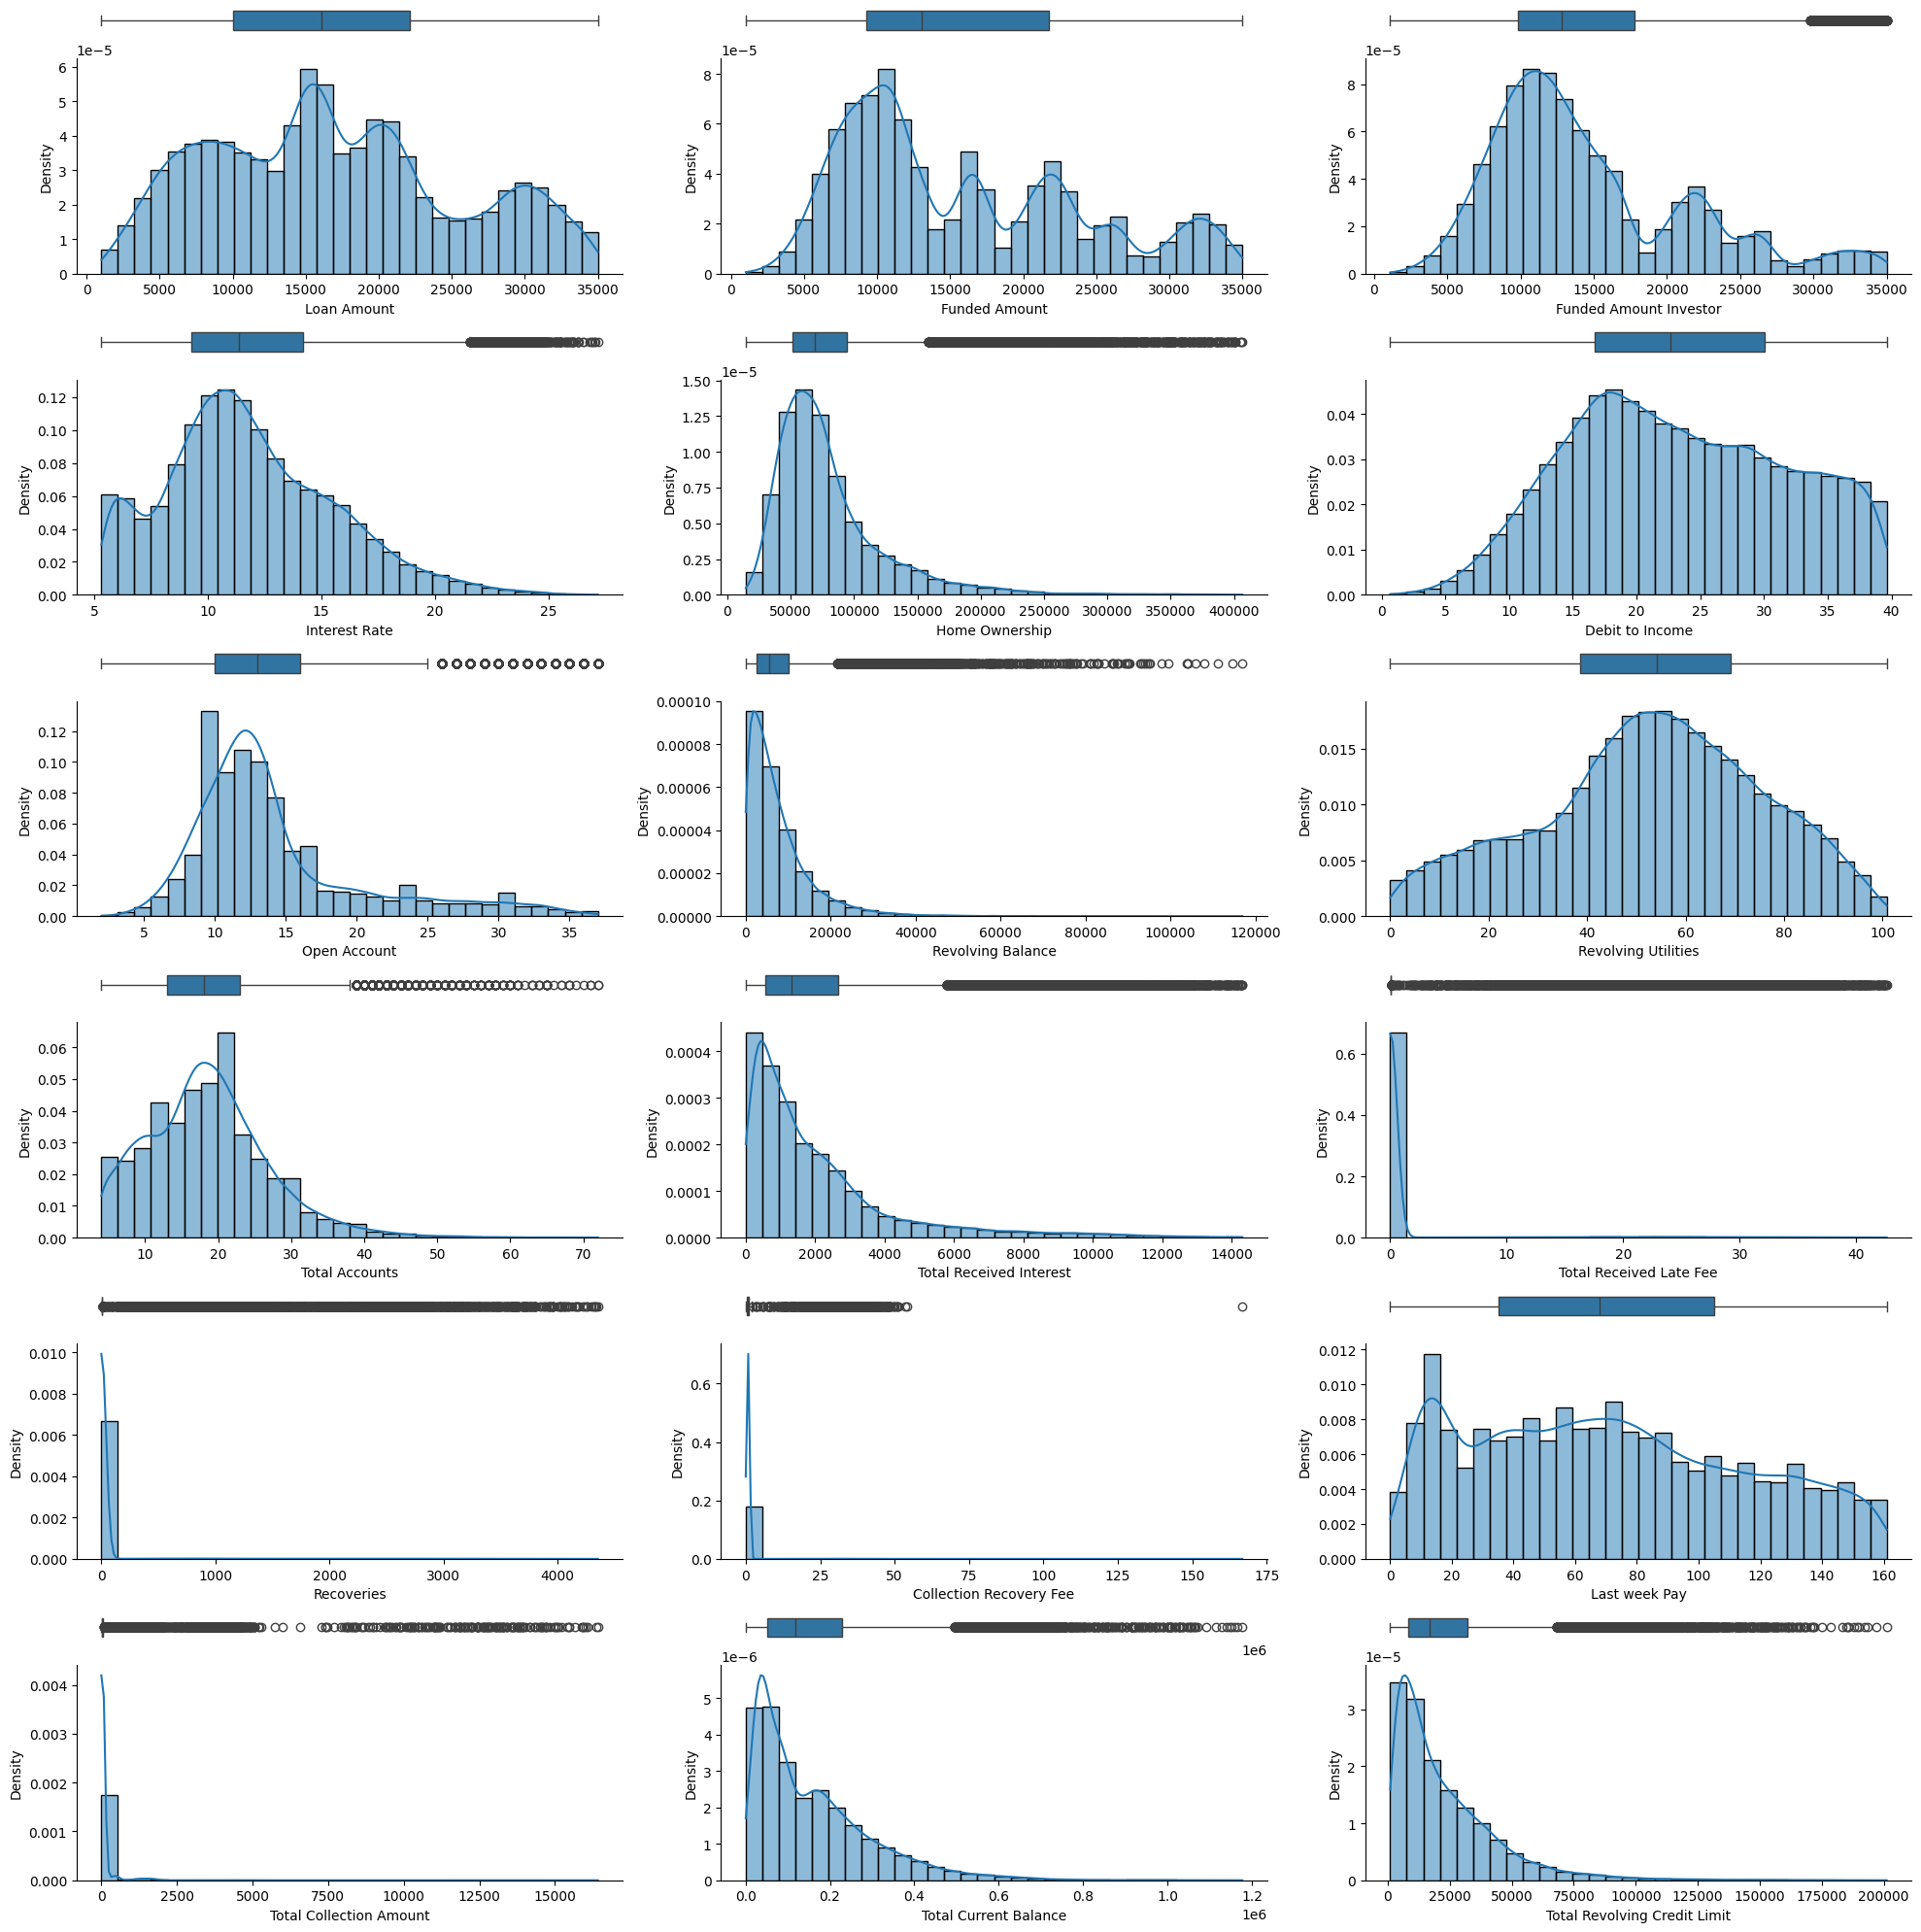

In [33]:
# let's look at the distribution of these variables
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))
ax = ax.ravel()

for i, var in enumerate(continuous_num_vars):
    # Turn off the visible axes in the main subplot
    ax[i].set_visible(False)
    # Create the nested subplots within each cell of the main grid
    gs = ax[i].get_subplotspec().subgridspec(2, 1, height_ratios=[.1, .9])

    # Create boxplot in the first nested subplot, share the x-axis with the histogram
    ax_box = fig.add_subplot(gs[0], sharex=ax[i])
    sns.boxplot(x=X[var], ax=ax_box)
    
    # turn off all the ticks on the axes of the box plot
    ax_box.tick_params(left=False, bottom=False)
    # turn off the title on the box plot
    ax_box.set_xlabel('')
    # turn off all spines (edges) around the box plot
    sns.despine(ax=ax_box, left=True, top=True, right=True, bottom=True)

    # Create histogram in the second nested subplot, share x-axis with the boxplot
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    sns.histplot(x=X[var], bins=30, kde=True, stat='density', ax=ax_hist)
    # Remove x-axis ticks from the boxplot (to avoid double labels)
    plt.setp(ax_box.get_xticklabels(), visible=False)

    # Remove extra spines
    sns.despine(ax=ax_hist)

# Increase distance between rows
plt.subplots_adjust(hspace=2.0)  # Adjust this value as needed
plt.tight_layout()
plt.show()

We see many continuous variables are (heavily) right-skewed. So, before applying optimal binning and WoE transformation, we'll need handle outliers and apply some transformation to normalize the distributions.

In [34]:
# create OutlierCapper class
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=None, upper_quantile=None):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.lower_bound_ = X.quantile(self.lower_quantile)
        self.upper_bound_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].clip(lower=self.lower_bound_[var], upper=self.upper_bound_[var])
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [35]:
# create a ColumnTransformer to apply OutlierCapper on our continuous variable
# define the variables that needs to be capped
capped_num_vars = [
    'Funded Amount Investor',
    'Interest Rate',
    'Home Ownership',
    'Open Account',
    'Revolving Balance',
    'Total Accounts',
    'Total Received Interest',
    'Total Received Late Fee',
    'Recoveries',
    'Collection Recovery Fee',
    'Total Collection Amount',
    'Total Current Balance',
    'Total Revolving Credit Limit'
]

outlier_cap = ColumnTransformer(
    transformers=[
        ('outlier_cap', 
         OutlierCapper(lower_quantile=0.05, upper_quantile=0.95), 
         capped_num_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

The majority of numerical variables' distributions are right-skewed and leptokurtic. Therefore, before discretizing them and applying encoding methods (like Weight of Evidence), we need to transform these variables. There are several methods as below:

1. The **logarithmic transformation** is typically used to handle positively skewed distribution by compressing the values. It converts a variable X using the natural logarithm.
$$X' = log(X+c)$$
Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $c$ is a constant added to X to handle cases where $X <= 0$ (commonly set to 1 to avoid taking log of 0)

2. The **Box-Cox transformation** is more flexible than the log transformation because it inlcudes a parameter $\lambda$ that adjusts the transformation depending on the skewness of the distribution.

$$
X' = 
\begin{cases}
\frac{(X^\lambda - 1)}{\lambda} & \text{if } \lambda \neq 0 \\
log(X) & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $\lambda$ is a parameter that can be optimized to best normalize the data

3. The **Yeo-Johnson transformation** is an extension of the Box-Cox transformation that is no longer constrained to positive values.
$$
X' = 
\begin{cases} 
\frac{((X + 1)^{\lambda} - 1)}{\lambda} & \text{if } \lambda \neq 0 \text{ and } X \geq 0 \\ 
-\frac{((-X + 1)^{2 - \lambda} - 1)}{2 - \lambda} & \text{if } \lambda \neq 2 \text{ and } X < 0 \\ 
\ln(X + 1) & \text{if } \lambda = 0 \text{ and } X \geq 0 \\ 
-\ln(-X + 1) & \text{if } \lambda = 2 \text{ and } X < 0 
\end{cases}
$$

In [36]:
# initialize a PowerTransformer to apply Yeo-Johnson transformation
yeojohnson_transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson_transformer', 
         PowerTransformer(method='yeo-johnson', standardize=False), 
         continuous_num_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

Now we can set up the WoETransformer for these continuous variables.

In [37]:
num_continuous_woe = WoETransformer(features=continuous_num_vars,
                                       dtype='numerical',
                                       solver='cp',
                                       monotonic_trend='auto')

In [38]:
# Create the pipeline for numerical variables, we'll do the fit and transform later
num_woe_pipeline = Pipeline(steps=[
    ('num_discrete_woe', num_discrete_woe),
    ('outlier_cap', outlier_cap),
    ('yeojohnson_transformer', yeojohnson_transformer),
    ('num_continuous_woe', num_continuous_woe)
])

In [39]:
# X_trans_num = num_woe_pipeline.fit_transform(X, y)

In [40]:
# X_trans_num.head()

## 6. Combined Preprocessing Pipeline

Now that we have 2 pipelines for handling categorical and numerical variables, we can combine them into 1 pipeline and use it to transform our variables.

In [41]:
preprocessing_pipeline = Pipeline(steps=[
    ('drop_quasi_constant', drop_quasi_constant),
    ('drop_duplicate', drop_duplicate),
    ('cat_woe_pipeline', cat_woe_pipeline),
    ('num_woe_pipeline', num_woe_pipeline),
])

In [42]:
# fit the combined pipeline
preprocessing_pipeline.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('drop_quasi_constant', DropQuasiConstantFeatures()),
                ('drop_duplicate',
                 DropDuplicateFeatures(missing_values='raise')),
                ('cat_woe_pipeline',
                 Pipeline(steps=[('loan_title_clean', LoanTitleCleanUp()),
                                 ('batch_num_extract', BatchNumberExtractor()),
                                 ('cat_ordinal_enc',
                                  CustomOrdinalEncoder(features=['Grade',
                                                                 'Sub Grade'])),
                                 ('cat_ordinal_woe',
                                  WoETr...
                                                           'Investor',
                                                           'Interest Rate',
                                                           'Home Ownership',
                                                           'Debit to Income',
                                                           'Open Account',
                                                           'Revolving Balance',
                                                           'Revolving '
                                                           'Utilities',
                                                           'Total Accounts',
                                                           'Total Received '
                                                           'Interest',
                                                           'Total Received '
                                                           'Late Fee',
                                                           'Recoveries',
                                                           'Collection '
                                                           'Recovery Fee',
                                                           'Last week Pay',
                                                           'Total Collection '
                                                           'Amount',
                                                           'Total Current '
                                                           'Balance',
                                                           'Total Revolving '
                                                           'Credit Limit'],
                                                 user_splits={},
                                                 user_splits_fixed={}))]))])

In [43]:
# transform our data
X = preprocessing_pipeline.transform(X)

In [44]:
X.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Open Account,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Term,Batch Enrolled,Grade,Sub Grade,Employment Duration,Verification Status,Loan Title,Delinquency - two years,Inquires - six months,Public Record,Initial List Status,Collection 12 months Medical
0,0.023316,0.050073,0.009129,0.001258,-0.060742,-0.020985,0.046720,-0.048317,-0.016089,-0.009052,-0.00896,0.095887,0.013483,-0.022531,0.020226,0.025656,-0.045857,-0.010737,-0.053486,-0.028286,0.044919,-0.017769,0.046700,0.004705,0.033829,-0.006381,-0.000678,0.008211,0.043768,-0.000349
1,-0.160154,-0.012135,0.009129,0.001258,0.017441,-0.020985,-0.013294,0.181572,-0.016089,0.030875,-0.00896,-0.026382,0.013483,0.021830,-0.029778,-0.127796,-0.030941,-0.022916,-0.053486,-0.156302,-0.016397,-0.017769,-0.037349,-0.010355,0.033829,0.008845,-0.000678,0.008211,-0.049087,-0.000349
2,-0.019710,-0.012135,-0.028001,0.001258,-0.002069,-0.009102,0.046720,0.022728,0.134220,0.030875,-0.00896,-0.165465,-0.003864,0.206933,-0.023064,-0.016243,0.011259,-0.022916,-0.053486,-0.001099,-0.069101,-0.017769,0.046700,-0.010355,0.033829,0.008845,-0.000678,0.008211,0.043768,-0.000349
3,0.189153,0.062825,0.013747,0.001258,-0.060742,0.007638,-0.090891,-0.014030,-0.016089,-0.009052,-0.00896,-0.026382,-0.087787,-0.022531,0.160393,-0.021255,0.003130,-0.026967,-0.053486,-0.001099,-0.016397,-0.017769,0.046700,-0.010355,0.033829,-0.006381,-0.000678,0.008211,0.043768,-0.000349
4,0.015998,-0.012135,0.009129,0.001258,0.017441,-0.020985,0.046720,0.022728,-0.093137,0.123752,-0.00896,-0.165465,-0.061885,-0.078176,0.015365,-0.127796,0.011259,-0.022916,-0.053486,0.059266,-0.016397,-0.017769,0.046700,-0.010355,-0.017504,-0.006381,0.005891,-0.107256,0.043768,-0.000349


In [45]:
# let's save our pipeline (for reuse later)
import pickle

with open('preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(preprocessing_pipeline, file)

In [46]:
# let's also save our preprocessed train dataset
X.to_csv('./data/X_train.csv', index=False)
y.to_csv('./data/y_train.csv', index=False)

## 7. Explore feature correlation

In [47]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

In [48]:
X_train.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Open Account,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Term,Batch Enrolled,Grade,Sub Grade,Employment Duration,Verification Status,Loan Title,Delinquency - two years,Inquires - six months,Public Record,Initial List Status,Collection 12 months Medical
0,0.023316,0.050073,0.009129,0.001258,-0.060742,-0.020985,0.046720,-0.048317,-0.016089,-0.009052,-0.00896,0.095887,0.013483,-0.022531,0.020226,0.025656,-0.045857,-0.010737,-0.053486,-0.028286,0.044919,-0.017769,0.046700,0.004705,0.033829,-0.006381,-0.000678,0.008211,0.043768,-0.000349
1,-0.160154,-0.012135,0.009129,0.001258,0.017441,-0.020985,-0.013294,0.181572,-0.016089,0.030875,-0.00896,-0.026382,0.013483,0.021830,-0.029778,-0.127796,-0.030941,-0.022916,-0.053486,-0.156302,-0.016397,-0.017769,-0.037349,-0.010355,0.033829,0.008845,-0.000678,0.008211,-0.049087,-0.000349
2,-0.019710,-0.012135,-0.028001,0.001258,-0.002069,-0.009102,0.046720,0.022728,0.134220,0.030875,-0.00896,-0.165465,-0.003864,0.206933,-0.023064,-0.016243,0.011259,-0.022916,-0.053486,-0.001099,-0.069101,-0.017769,0.046700,-0.010355,0.033829,0.008845,-0.000678,0.008211,0.043768,-0.000349
3,0.189153,0.062825,0.013747,0.001258,-0.060742,0.007638,-0.090891,-0.014030,-0.016089,-0.009052,-0.00896,-0.026382,-0.087787,-0.022531,0.160393,-0.021255,0.003130,-0.026967,-0.053486,-0.001099,-0.016397,-0.017769,0.046700,-0.010355,0.033829,-0.006381,-0.000678,0.008211,0.043768,-0.000349
4,0.015998,-0.012135,0.009129,0.001258,0.017441,-0.020985,0.046720,0.022728,-0.093137,0.123752,-0.00896,-0.165465,-0.061885,-0.078176,0.015365,-0.127796,0.011259,-0.022916,-0.053486,0.059266,-0.016397,-0.017769,0.046700,-0.010355,-0.017504,-0.006381,0.005891,-0.107256,0.043768,-0.000349


In [49]:
y_train.head()

,Loan Status
0,0
1,0
2,0
3,0
4,0


In [50]:
X_corr = X_train.corr()

In [51]:
df_corr = pd.concat([X_train, y_train], axis=1).corr()

In [52]:
df_corr['Loan Status'].sort_values(ascending=False)

Loan Status                     1.000000
Inquires - six months          -0.000578
Collection 12 months Medical   -0.000686
Verification Status            -0.003129
Sub Grade                      -0.007414
Delinquency - two years        -0.007450
Public Record                  -0.008774
Loan Title                     -0.009116
Debit to Income                -0.009754
Revolving Utilities            -0.011751
Total Revolving Credit Limit   -0.012411
Total Received Interest        -0.012467
Grade                          -0.012705
Interest Rate                  -0.013286
Initial List Status            -0.013445
Last week Pay                  -0.013846
Funded Amount                  -0.013969
Open Account                   -0.014433
Revolving Balance              -0.014472
Employment Duration            -0.015447
Recoveries                     -0.016155
Home Ownership                 -0.016540
Total Current Balance          -0.018030
Loan Amount                    -0.018367
Funded Amount In

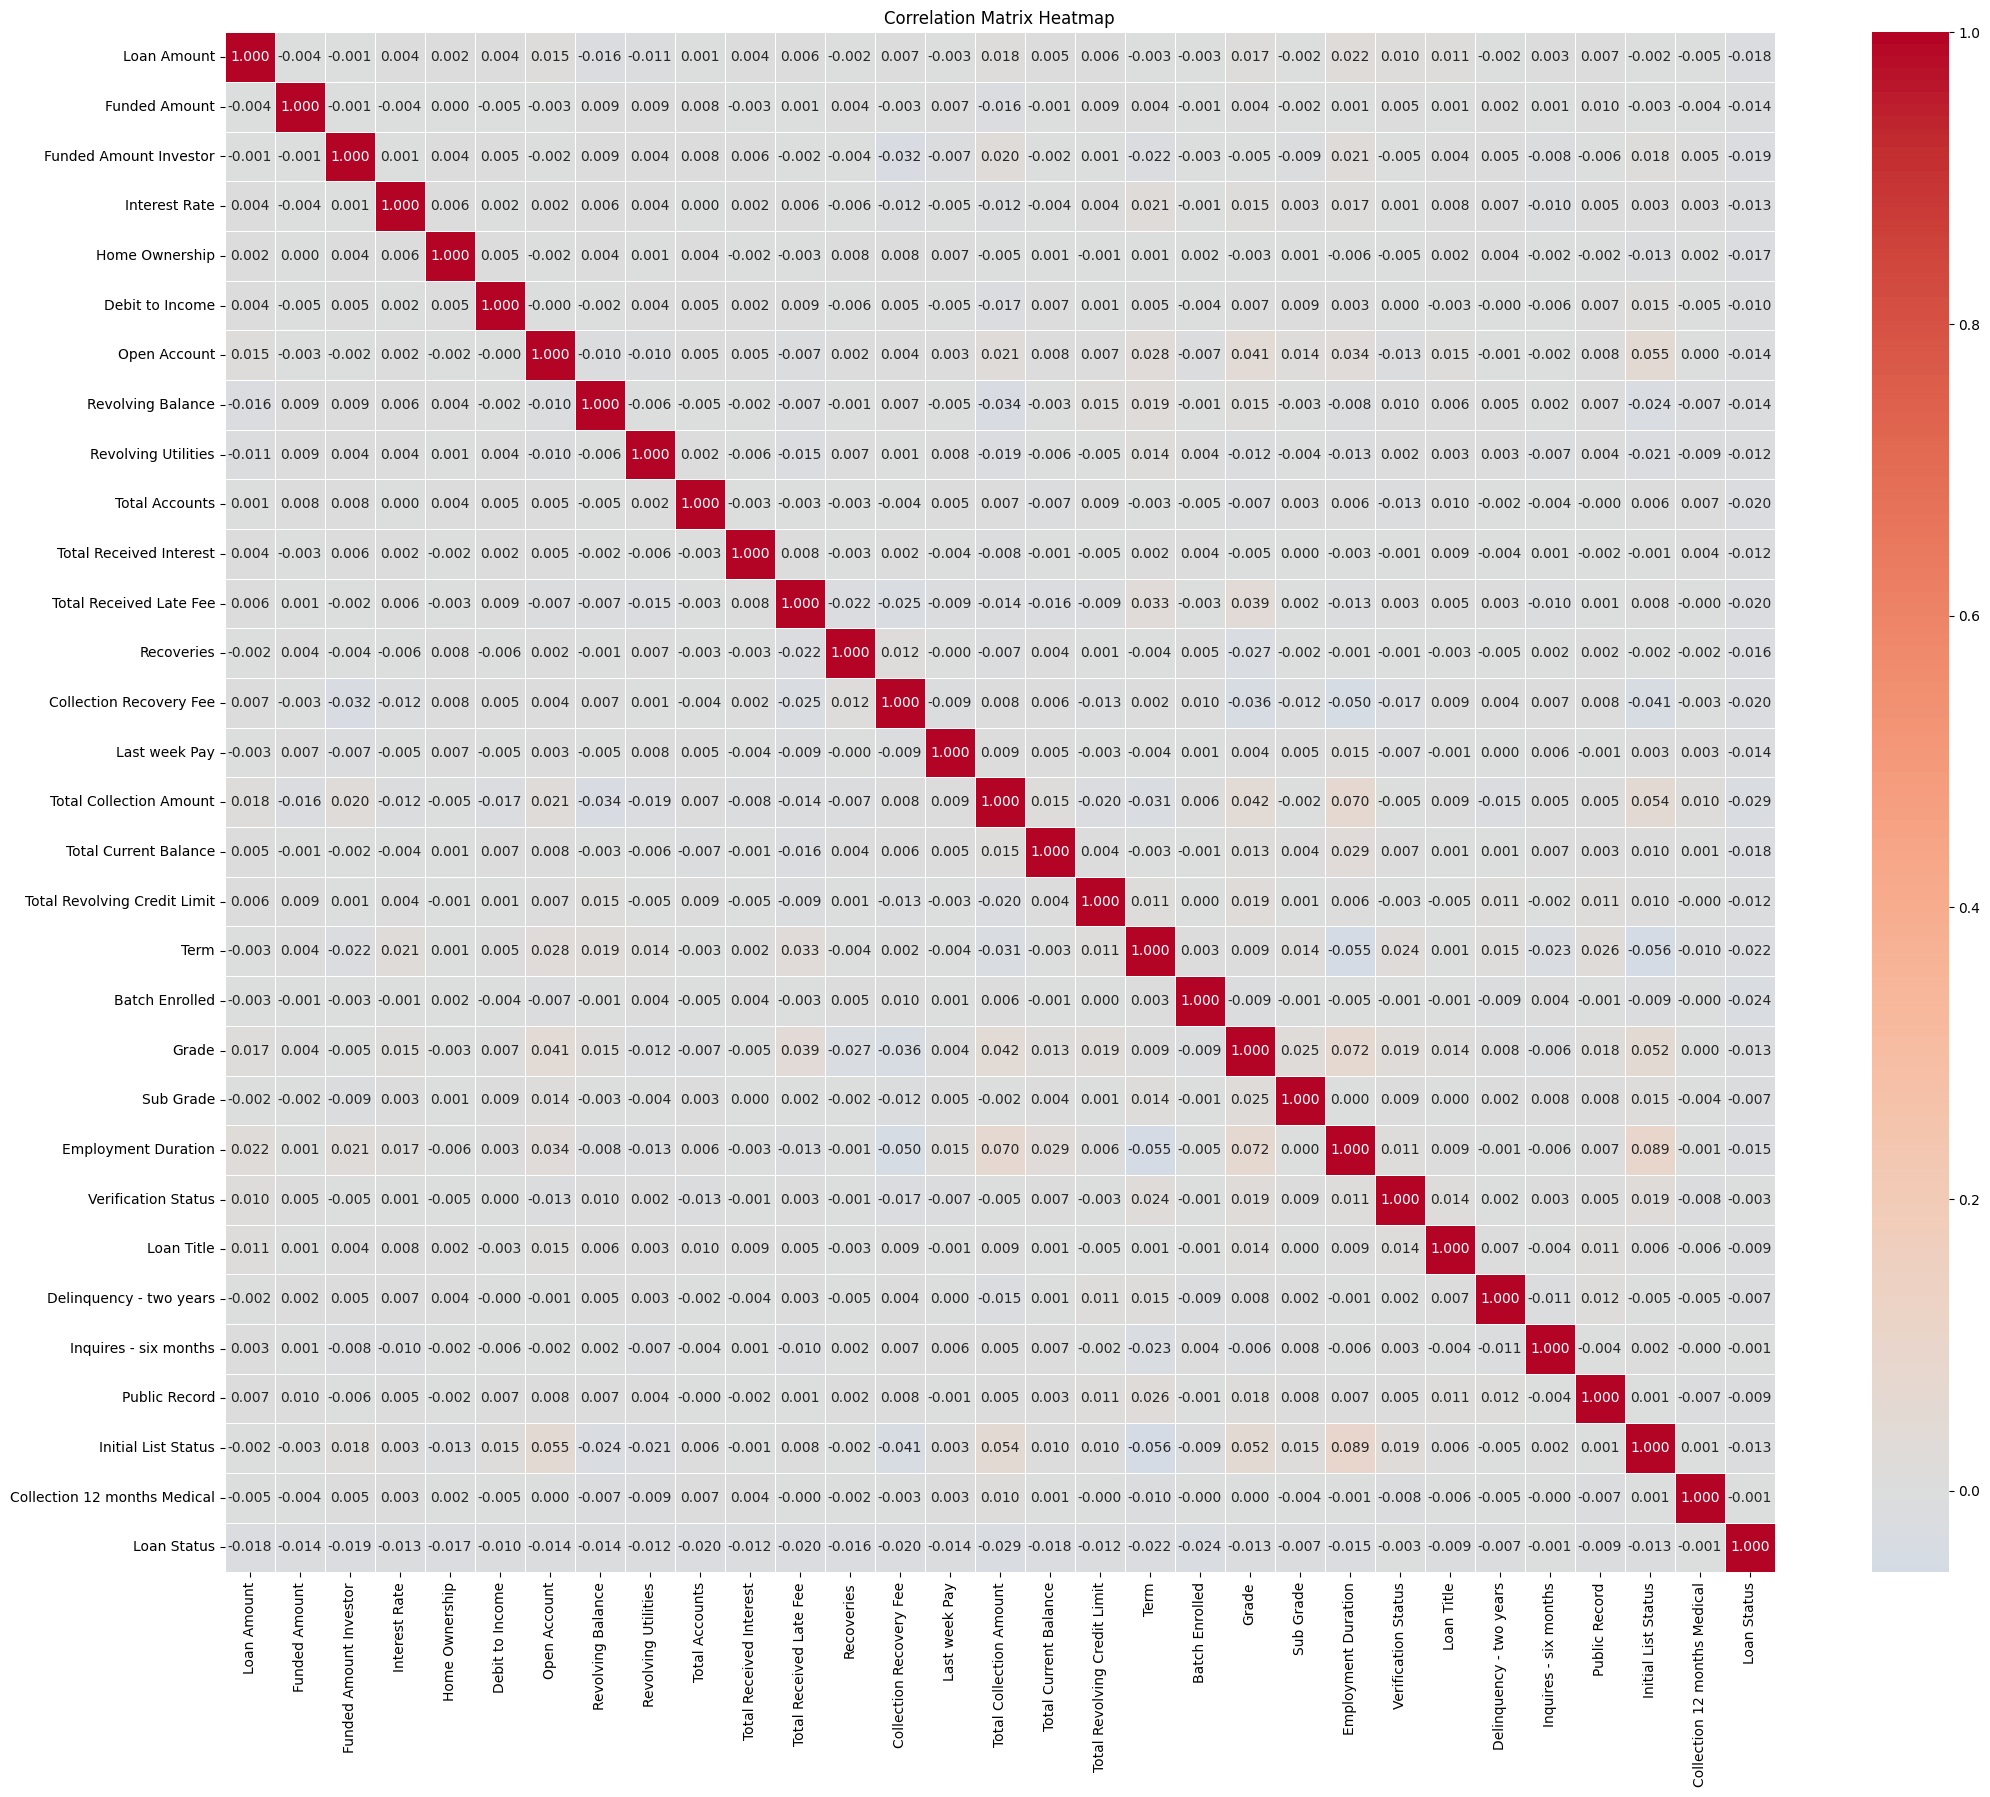

In [53]:
# plot the heatmap of feature correlation
plt.figure(figsize=(25,20))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0, linewidths=.5, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()

## 8. Fit a simple logistic regression with L1 penalty

In [75]:
feature_selector = SelectFromModel(
    estimator=LogisticRegression(C=1.0, penalty='l1', 
                                 solver='liblinear', 
                                 max_iter=300,
                                 random_state=10)
)

feature_selector.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectFromModel(estimator=LogisticRegression(max_iter=300, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [76]:
selected_features = X_train.columns[(feature_selector.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_features)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_selector.estimator_.coef_ == 0)))

total features: 30
selected features: 27
features with coefficients shrank to zero: 3


In [77]:
selected_features

Index(['Loan Amount', 'Funded Amount', 'Funded Amount Investor',
       'Interest Rate', 'Home Ownership', 'Debit to Income', 'Open Account',
       'Revolving Balance', 'Revolving Utilities', 'Total Accounts',
       'Total Received Interest', 'Total Received Late Fee', 'Recoveries',
       'Collection Recovery Fee', 'Last week Pay', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Term',
       'Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration',
       'Loan Title', 'Delinquency - two years', 'Public Record',
       'Initial List Status'],
      dtype='object')

In [54]:
# # test this pipeline on our test set
# with open('preprocessing_pipeline.pkl', 'rb') as file:
#     preprocessing_pipeline = pickle.load(file)

In [55]:
# # load the test set
# df_test = pd.read_csv('./data/test.csv')

In [56]:
# # check the number of rows and columns
# df_test.shape

In [57]:
# # Displays column names, complete (non-missing) cases per column, and datatype per column.
# df_test.info()

In [58]:
# # let's separate the data into target and variables
# target = 'Loan Status'

# y_test = df_test[target]
# X_test = df_test[[var for var in df_test.columns if var not in [target, 'ID']]]

In [59]:
# X_test.shape, y_test.shape

In [60]:
# # use the pipeline to transform the test set
# X_test = preprocessing_pipeline.transform(X_test)

In [61]:
# X_test.shape

In [62]:
# X_test.head()

In [63]:
# X_test.describe().T